<a href="https://colab.research.google.com/github/cesong2/Display-Sensor/blob/yngkyng/%EB%94%A5%ED%95%9C_%EB%B6%84%EC%84%9D1%2C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [4]:
#Load the data
telemetry_df = pd.read_csv("/content/PdM_telemetry.csv")
errors_df = pd.read_csv("/content/PdM_errors.csv")
maint_df = pd.read_csv("/content/PdM_maint.csv")
failures_df = pd.read_csv("/content/PdM_failures.csv")
machines_df = pd.read_csv("/content/PdM_machines.csv")

##1. 사용연식, 에러횟수, 교체횟수, 고장횟수 간 상관관계 찾기
* 사용연식 - machineID의 age (machines.csv)
* 에러횟수 - groupby machineID, count * (errors.csv)
* 교체횟수 - groupby machineID, count * (maint.csv)
* 고장횟수 - groupby machineID, count * (failure.csv)

In [5]:
# 필요한 데이터 추출
machines_age = pd.DataFrame(machines_df[['machineID','age']]).set_index('machineID')
machines_errors = pd.DataFrame(errors_df.groupby('machineID')['errorID'].count())
machines_maint = pd.DataFrame(maint_df.groupby('machineID')['comp'].count())
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())

In [6]:
# 추출한 데이터 합치기
df_machines = pd.concat([machines_age, machines_errors, machines_maint, machines_failures], axis=1)
df_machines.rename(columns={'errorID':'error', 'comp':'replace'},inplace=True)
df_machines

,age,error,replace,failure
machineID,,,,
1,18,35,37,7.0
2,7,28,32,4.0
3,8,39,37,5.0
4,7,31,33,6.0
5,2,38,35,7.0
...,...,...,...,...
96,10,39,33,5.0
97,14,45,34,8.0
98,20,45,37,16.0


In [7]:
# 상관관계 찾기 (피어슨 상관계수 사용)
df_machines.corr(method = "pearson")

,age,error,replace,failure
age,1.000000,0.106931,0.075445,0.476459
error,0.106931,1.000000,-0.026558,0.483735
replace,0.075445,-0.026558,1.000000,-0.030258
failure,0.476459,0.483735,-0.030258,1.000000


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49832 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_

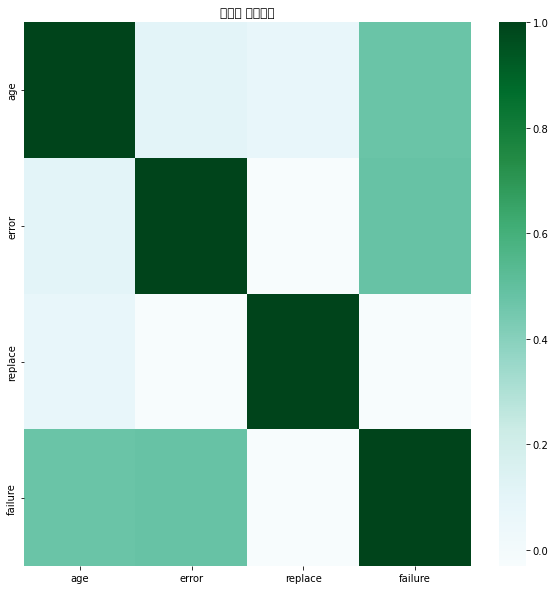

In [8]:
# 히트맵 시각화
matplotlib.rcParams['font.family'] = "NaNumGothic"  #나눔고딕체 사용
colormap = plt.cm.BuGn  #색설정 : BlueGreen
plt.figure(figsize = (10,10))
plt.title("피어슨 상관계수")
sns.heatmap(df_machines.astype(float).corr(), cmap=colormap)

## 2. 요인들(전압, 회전, 압력, 진동)의 이상치가 고장과 연관성이 있는지
* 요인들 -> telemetry.csv
* 고장 -> failures.csv

In [9]:
#기계별 고장 데이터
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())

In [10]:
telemetry_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1.0,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1.0,162.879223,402.747490,95.460525,43.413973


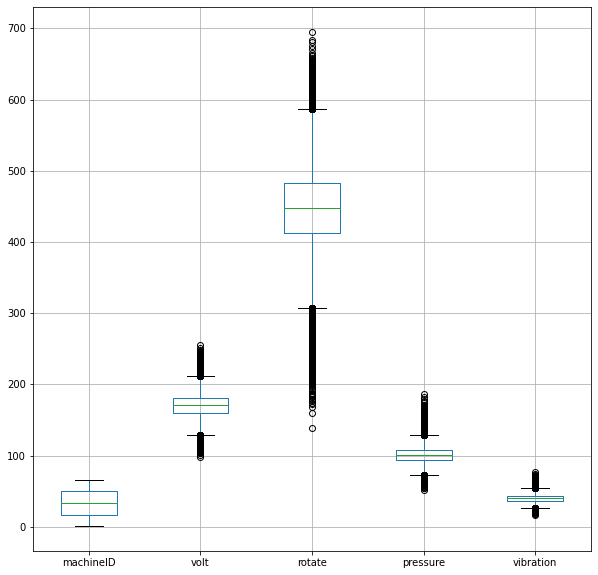

In [11]:
# 각 요인별 이상치 찾기
telemetry_df.boxplot(figsize=(10,10))
plt.show()

In [12]:
import numpy as np

In [17]:
# 각 요인별 이상치 데이터 추출
def outlier(df, column):
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (IQR * 1.5)
    maximum = Q3 + (IQR * 1.5)
    ###여기서부터 ㄴㄴ
    return pd.DataFrame(df['machineID'], df[[(df[column] > maximum) or (df[column] < minimum)]])

volt_outlier = outlier(telemetry_df, 'volt')
rotate_outlier = outlier(telemetry_df, 'rotate')
pressure_outlier = outlier(telemetry_df, 'pressure')
vibration_outlier = outlier(telemetry_df, 'vibration')

ValueError: ignored

In [ ]:
# 이상치 데이터에서 기계별로 groupby, 각 이상치가 몇번씩 측정되었는지 count
outliers = pd.DataFrame(failures_df.groupby('machineID')['volt'].count())

In [ ]:
# 기계별 고장 횟수와 이상치별 측정 횟수 연관성 찾기